<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAMed_Endo_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Urvi's Endonasal DataLoader

17:33, Sep 27 - Resolved without actually having to test the dataloader since it was an issue with having a learning rate that is too high.

In [1]:
!git clone https://github.com/hitachinsk/SAMed.git
%cd SAMed

Cloning into 'SAMed'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 225 (delta 42), reused 29 (delta 29), pack-reused 167 (from 1)
Receiving objects: 100% (225/225), 636.92 KiB | 13.00 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/SAMed


In [2]:
!gdown 157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5
!gdown 1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
!gdown 1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
!unzip -q Endonasal_Slices_All.zip

Downloading...
From (original): https://drive.google.com/uc?id=157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5
From (redirected): https://drive.google.com/uc?id=157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5&confirm=t&uuid=fbc367cf-b8c3-4eb7-ae48-9e498026d732
To: /content/SAMed/Endonasal_Slices_All.zip
100% 914M/914M [00:36<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/SAMed/epoch_159.pth
100% 19.7M/19.7M [00:00<00:00, 163MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
From (redirected): https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg&confirm=t&uuid=01500747-5806-4fc2-8547-1bb12843a74b
To: /content/SAMed/sam_vit_b_01ec64.pth
100% 375M/375M [00:07<00:00, 47.4MB/s]


In [3]:
!pip install -q einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: deprecated, use  4.5.4.60
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00

In [4]:
!pip3 -q install tqdm imageio[pyav] imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 17.5 MB/s eta 0:00:00


/content/SAMed
Training on: train sample size: 7966 test sample size: 3414


<ipython-input-5-fc4575bc6682>:82: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(self.img_path_all[index])
<ipython-input-5-fc4575bc6682>:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = iio.imread(self.mask_path_all[index])


tensor([0], dtype=torch.uint8)


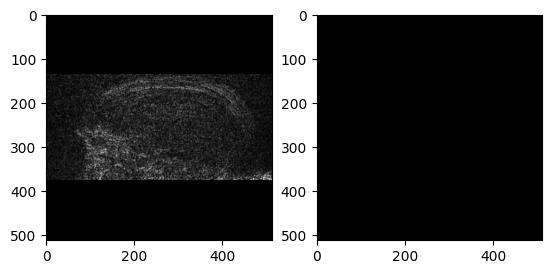

In [5]:
%cd /content/SAMed
import os
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
from scipy import ndimage
import random
from PIL import Image
import cv2

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label


class RandomGenerator(object):
    def __init__(self, output_size, low_res):
        self.output_size = output_size
        self.low_res = low_res

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label_h, label_w = label.shape
        low_res_label = zoom(label, (self.low_res[0] / label_h, self.low_res[1] / label_w), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        image = repeat(image, 'c h w -> (repeat c) h w', repeat=3)
        label = torch.from_numpy(label.astype(np.float32))
        low_res_label = torch.from_numpy(low_res_label.astype(np.float32))
        sample = {'image': image, 'label': label.long(), 'low_res_label': low_res_label.long()}
        return sample

class EndonasalDataset(Dataset):
    def __init__(self, root='endonasal_train', low_res=None, isTrain=False):
        self.img_path_all = glob(root + '/mri_t1c/*.png')  # Update the path and pattern
        # print(self.img_path_all)
        self.mask_path_all = [img_path.replace('mri_t1c', 'mri_masks') for img_path in self.img_path_all]
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        if not os.path.exists(self.img_path_all[index]):
            raise ValueError(f"Image file not found: {self.img_path_all[index]}")

        image = iio.imread(self.img_path_all[index])

        # Add a check to handle potential errors during image reading
        if image is None:
            raise ValueError(f"Failed to read image: {self.img_path_all[index]}")

        image = normalise_intensity(image)
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)

        # Check if the mask file exists
        if not os.path.exists(self.mask_path_all[index]):
            raise ValueError(f"Mask file not found: {self.mask_path_all[index]}")

        label = iio.imread(self.mask_path_all[index])

        if label is None:
            raise ValueError(f"Failed to read mask: {self.mask_path_all[index]}")

        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)

        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        image = torch.from_numpy(image).float() # Converting double to single precision float
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label}

        return sample

seed = 1234
batch_size = 10
# Need to change the name of the Endonasal_Slices folder after gdowning
db_train = EndonasalDataset(root='/content/SAMed/Endonasal_Slices_All/Train', low_res=128, isTrain=True)
db_test = EndonasalDataset(root='/content/SAMed/Endonasal_Slices_All/Test', low_res=128)
# print('Train Sample:', len(db_train), 'Test Sample:', len(db_test))


def worker_init_fn(worker_id):
        random.seed(seed + worker_id)

trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True,
                             worker_init_fn=worker_init_fn)
validloader = DataLoader(db_test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,
                             worker_init_fn=worker_init_fn)

print('Training on:', 'train sample size:', len(db_train), 'test sample size:', len(db_test))
import matplotlib.pyplot as plt
idx = 0
for sample_b in validloader:
    # print(sample_b['image'][idx].shape, sample_b['label'][idx].shape)
    print(sample_b['label'][idx].unique())
    break

plt.subplot(121); plt.imshow(sample_b['image'][idx][0], cmap='gray')
plt.subplot(122); plt.imshow(sample_b['label'][idx], cmap='gray')

In [12]:
%cd /content/SAMed
import argparse
import logging
import os
import sys
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from tqdm import tqdm
from utils import DiceLoss, Focal_loss

from importlib import import_module

from sam_lora_image_encoder import LoRA_Sam
from segment_anything import sam_model_registry
from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss, Focal_loss
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# from trainer import trainer_synapse
from icecream import ic

def calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    low_res_logits = outputs['low_res_logits']
    loss_ce = ce_loss(low_res_logits, low_res_label_batch[:].long())
    loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice

def trainer_synapse(args, model, snapshot_path, multimask_output, low_res):
    # from datasets.dataset_synapse import Synapse_dataset, RandomGenerator
    logging.basicConfig(filename=snapshot_path + "/log.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))
    base_lr = args.base_lr
    num_classes = args.num_classes
    batch_size = args.batch_size * args.n_gpu
    # max_iterations = args.max_iterations
    # db_train = Synapse_dataset(base_dir=args.root_path, list_dir=args.list_dir, split="train",
    #                            transform=transforms.Compose(
    #                                [RandomGenerator(output_size=[args.img_size, args.img_size], low_res=[low_res, low_res])]))
    # print("The length of train set is: {}".format(len(db_train)))
    db_train = EndonasalDataset(root=(args.root_path+'/Train'), low_res=128, isTrain=True)
    db_valid = EndonasalDataset(root=(args.root_path+'/Test'), low_res=128)
    # trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    # testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', 'train sample size:', len(db_train), 'test sample size:', len(db_valid), 'batch:', batch_size)


    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    validloader = DataLoader(db_valid, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    if args.n_gpu > 1:
        model = nn.DataParallel(model)
    model.train()
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(num_classes + 1)
    if args.warmup:
        b_lr = base_lr / args.warmup_period
    else:
        b_lr = base_lr
    if args.AdamW:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, momentum=0.9, weight_decay=0.0001)  # Even pass the model.parameters(), the `requires_grad=False` layers will not update
    writer = SummaryWriter(snapshot_path + '/log')
    iter_num = 0
    max_epoch = args.max_epochs
    stop_epoch = args.stop_epoch
    max_iterations = args.max_epochs * len(trainloader)  # max_epoch = max_iterations // len(trainloader) + 1
    logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))
    best_performance = 0.0
    # iterator = tqdm(range(max_epoch), ncols=70)
    best_epoch = 0
    best_loss_val = np.inf
    for epoch_num in range(max_epoch):
        for i_batch, sampled_batch in enumerate(tqdm(trainloader)):
            image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
            low_res_label_batch = sampled_batch['low_res_label']
            image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
            low_res_label_batch = low_res_label_batch.cuda()
            # print('image_batchimage_batch:',image_batch.shape)
            # assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
            outputs = model(image_batch, multimask_output, args.img_size)
            loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, args.dice_param)
            # print("Epoch:{}/{}, loss:{}, loss_ce:{}, loss_dice:{}".format(epoch_num, iterator, loss.item(), loss_ce.item(), loss_dice.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if args.warmup and iter_num < args.warmup_period:
                lr_ = base_lr * ((iter_num + 1) / args.warmup_period)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                if args.warmup:
                    shift_iter = iter_num - args.warmup_period
                    assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                else:
                    shift_iter = iter_num
                lr_ = base_lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_

            iter_num = iter_num + 1
            writer.add_scalar('info/lr', lr_, iter_num)
            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/loss_ce', loss_ce, iter_num)
            writer.add_scalar('info/loss_dice', loss_dice, iter_num)

            logging.info('iteration %d : loss : %f, loss_ce: %f, loss_dice: %f' % (iter_num, loss.item(), loss_ce.item(), loss_dice.item()))

            if iter_num % 20 == 0:
                image = image_batch[1, 0:1, :, :]
                image = (image - image.min()) / (image.max() - image.min())
                writer.add_image('train/Image', image, iter_num)
                output_masks = outputs['masks']
                output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)
                writer.add_image('train/Prediction', output_masks[1, ...] * 50, iter_num)
                labs = label_batch[1, ...].unsqueeze(0) * 50
                writer.add_image('train/GroundTruth', labs, iter_num)
        with torch.no_grad():
            for i_batch, sampled_batch in enumerate(validloader):
                image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
                low_res_label_batch = sampled_batch['low_res_label']
                image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
                low_res_label_batch = low_res_label_batch.cuda()
                # assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
                outputs = model(image_batch, multimask_output, args.img_size)
                loss_val, _, _ = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, args.dice_param)

        if loss_val < best_loss_val:
            best_loss_val = loss_val
            best_epoch = epoch_num
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_lora_parameters(save_mode_path)
            except:
                model.module.save_lora_parameters(save_mode_path)

        print("Epoch:{}/{}, loss:{}, best loss:{}, best epoch:{}".format(epoch_num, max_epoch, loss_val, best_loss_val, best_epoch))
        # print("Epoch:{}/{}, loss:{}".format(epoch_num, iterator, loss.item())
        # save_interval = 20 # int(max_epoch/6)
        # if (epoch_num + 1) % save_interval == 0:
        #     save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
        #     try:
        #         model.save_lora_parameters(save_mode_path)
        #     except:
        #         model.module.save_lora_parameters(save_mode_path)
        #     logging.info("save model to {}".format(save_mode_path))

        if epoch_num >= max_epoch - 1 or epoch_num >= stop_epoch - 1:
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_lora_parameters(save_mode_path)
            except:
                model.module.save_lora_parameters(save_mode_path)
            logging.info("save model to {}".format(save_mode_path))
            iterator.close()
            break

    writer.close()
    return "Training Finished!"



parser = argparse.ArgumentParser()
parser.add_argument('--root_path', type=str,
                    default='/data/LarryXu/Synapse/preprocessed_data/train_npz', help='root dir for data')
parser.add_argument('--output', type=str, default='/output/sam/results')
parser.add_argument('--dataset', type=str,
                    default='Synapse', help='experiment_name')
parser.add_argument('--list_dir', type=str,
                    default='./lists/lists_Synapse', help='list dir')
parser.add_argument('--num_classes', type=int,
                    default=2, help='output channel of network')
parser.add_argument('--max_iterations', type=int,
                    default=30000, help='maximum epoch number to train')
parser.add_argument('--max_epochs', type=int,
                    default=200, help='maximum epoch number to train')
parser.add_argument('--stop_epoch', type=int,
                    default=160, help='maximum epoch number to train')
parser.add_argument('--batch_size', type=int,
                    default=4, help='batch_size per gpu')
parser.add_argument('--n_gpu', type=int, default=1, help='total gpu')
parser.add_argument('--deterministic', type=int, default=1,
                    help='whether use deterministic training')
parser.add_argument('--base_lr', type=float, default=0.0005,
                    help='segmentation network learning rate')
parser.add_argument('--img_size', type=int,
                    default=512, help='input patch size of network input')
parser.add_argument('--seed', type=int,
                    default=1234, help='random seed')
parser.add_argument('--vit_name', type=str,
                    default='vit_b', help='select one vit model')
parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                    help='Pretrained checkpoint')
parser.add_argument('--lora_ckpt', type=str, default=None, help='Finetuned lora checkpoint')
parser.add_argument('--rank', type=int, default=6, help='Rank for LoRA adaptation')
parser.add_argument('--warmup', action='store_true', help='If activated, warp up the learning from a lower lr to the base_lr')
parser.add_argument('--warmup_period', type=int, default=250,
                    help='Warp up iterations, only valid whrn warmup is activated')
parser.add_argument('--AdamW', action='store_true', help='If activated, use AdamW to finetune SAM model')
parser.add_argument('--module', type=str, default='sam_lora_image_encoder')
parser.add_argument('--dice_param', type=float, default=0.8)

if 'ipykernel' in sys.modules:
    args = parser.parse_args([])
else:
    args = parser.parse_args()

args.output_dir = 'results'
args.ckpt = 'sam_vit_b_01ec64.pth'
args.lora_ckpt = 'epoch_159.pth'
args.root_path = '/content/SAMed/Endonasal_Slices_All'
os.makedirs(args.output_dir, exist_ok = True)


if __name__ == "__main__":
    if not args.deterministic:
        cudnn.benchmark = True
        cudnn.deterministic = False
    else:
        cudnn.benchmark = False
        cudnn.deterministic = True

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    dataset_name = args.dataset
    dataset_config = {
        'Synapse': {
            'root_path': args.root_path,
            'list_dir': args.list_dir,
            'num_classes': args.num_classes,
        }
    }
    args.is_pretrain = True
    args.exp = dataset_name + '_' + str(args.img_size)
    snapshot_path = os.path.join(args.output, "{}".format(args.exp))
    snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
    snapshot_path += '_' + args.vit_name
    snapshot_path = snapshot_path + '_' + str(args.max_iterations)[
                                          0:2] + 'k' if args.max_iterations != 30000 else snapshot_path
    snapshot_path = snapshot_path + '_epo' + str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
    snapshot_path = snapshot_path + '_bs' + str(args.batch_size)
    snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
    snapshot_path = snapshot_path + '_s' + str(args.seed) if args.seed != 1234 else snapshot_path

    if not os.path.exists(snapshot_path):
        os.makedirs(snapshot_path)

    # register model
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                num_classes=args.num_classes,
                                                                checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()

    # net = LoRA_Sam(sam, args.rank).cuda()
    # if args.lora_ckpt is not None:
    #     net.load_lora_parameters(args.lora_ckpt)

    if args.num_classes > 1:
        multimask_output = True
    else:
        multimask_output = False

    low_res = img_embedding_size * 4

    config_file = os.path.join(snapshot_path, 'config.txt')
    config_items = []
    for key, value in args.__dict__.items():
        config_items.append(f'{key}: {value}\n')

    with open(config_file, 'w') as f:
        f.writelines(config_items)

    trainer = {'Synapse': trainer_synapse}
    trainer[dataset_name](args, net, snapshot_path, multimask_output, low_res)

/content/SAMed
Training on: train sample size: 7966 test sample size: 3414 batch: 4


  5%|▍         | 99/1992 [01:24<25:54,  1.22it/s]WARNING:tensorboardX.x2num:NaN or Inf found in input tensor.


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


100%|██████████| 1992/1992 [27:29<00:00,  1.21it/s]


NameError: name 'iterator' is not defined

In [ ]:
!nvidia-smi

Mon Oct 14 19:26:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              32W /  70W |   6929MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--